In [5]:
from sqlalchemy.engine import create_engine

In [6]:
engine = create_engine('bigquery://', credentials_path= 'key/iowa-liquor-sales-365322-12ff7a5498e6.json')

In [7]:
import pandas as pd
import matplotlib.ticker as tick
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import plotly.express as px

In [8]:
sql_statement = """
   SELECT 
  #EXTRACT(YEAR FROM date) AS year,
  SUM(volume_sold_liters) AS liters_sold,
  IF (county ='POTTAWATTA','POTTAWATTAMIE', county) AS county
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020,2021) AND county IN ("POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","WOODBURY","DUBUQUE","STORY","DALLAS","POTTAWATTA")
GROUP BY county 
ORDER BY liters_sold DESC
  """.strip()

In [9]:
df = pd.read_sql_query(sql_statement, engine)

In [10]:
#pal = sns.color_palette("tab10")
#pal.as_hex()

In [11]:
#hex_codes = pal.as_hex()[:]
#print(hex_codes)

In [12]:
sns.set(font_scale=1.4)

def reformat_large_tick_values(tick_val,pos):
    """
    Turns large tick values (in the billions, millions and thousands) such as 4500 into 4.5K and also appropriately turns 4000 into 4K (no zero after the decimal).
    """
    if tick_val >= 1000000000:
        val = round(tick_val/1000000000, 1)
        new_tick_format = '{:}B'.format(val)
    elif tick_val >= 1000000:
        val = round(tick_val/1000000, 1)
        new_tick_format = '{:}M'.format(val)
    elif tick_val >= 1000:
        val = round(tick_val/1000, 1)
        new_tick_format = '{:}K'.format(val)
    elif tick_val < 1000:
        new_tick_format = round(tick_val, 1)
    else:
        new_tick_format = tick_val

    # make new_tick_format into a string value
    new_tick_format = str(new_tick_format)
    
    # code below will keep 4.5M as is but change values such as 4.0M to 4M since that zero after the decimal isn't needed
    index_of_decimal = new_tick_format.find(".")
    
    if index_of_decimal != -1:
        value_after_decimal = new_tick_format[index_of_decimal+1]
        if value_after_decimal == "0":
            # remove the 0 after the decimal point since it's not needed
            new_tick_format = new_tick_format[0:index_of_decimal] + new_tick_format[index_of_decimal+2:]
            
    return new_tick_format

In [13]:
df

,liters_sold,county
0,19646575.23,POLK
1,8134584.43,LINN
2,6440681.99,SCOTT
3,5092119.68,JOHNSON
4,4972486.29,BLACK HAWK
5,3274895.58,POTTAWATTAMIE
6,3132042.70,WOODBURY
7,2887776.73,STORY
8,2867264.56,DUBUQUE
9,2240494.13,DALLAS


In [14]:
#remove plot grey default 
#sns.set(rc={'axes.facecolor':'white'})
#add box and ticks
#sns.set_style("ticks")
#sns.set_style("whitegrid")


In [50]:
colors = ['#1f77b4', '#9467bd', '#e377c2', '#17becf', '#2ca02c', '#bcbd22', '#FFEB3B', '#FFA000',  '#d62728',   '#873600']
county_colors =sns.color_palette(colors)


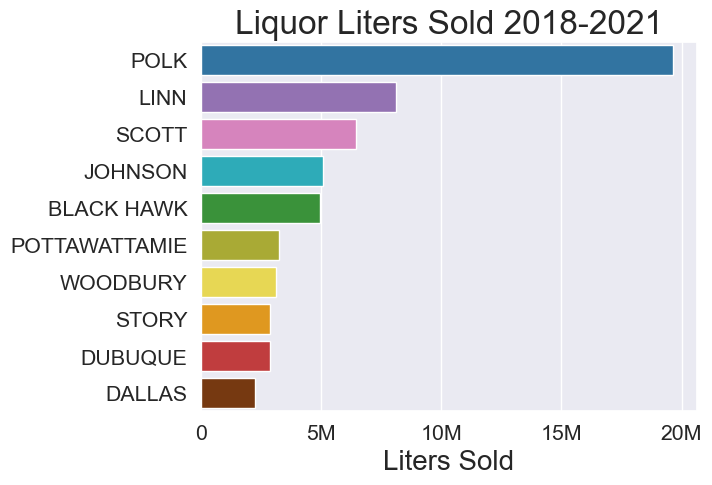

In [16]:
#sns.set_palette("customPalette")
sns.barplot( x = 'liters_sold', y = 'county', data=df,  palette= county_colors)
ax = plt.gca()
# Set label for x-axis
ax.set_xlabel( "Liters Sold" , size = 20 )
# Set label for y-axis
ax.set_ylabel(None, size = 20 )
  
# Set title for plot
ax.set_title( "Liquor Liters Sold 2018-2021"  , size = 24 )
#rename ax example: ax2
ax.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 45) 
 
plt.show()

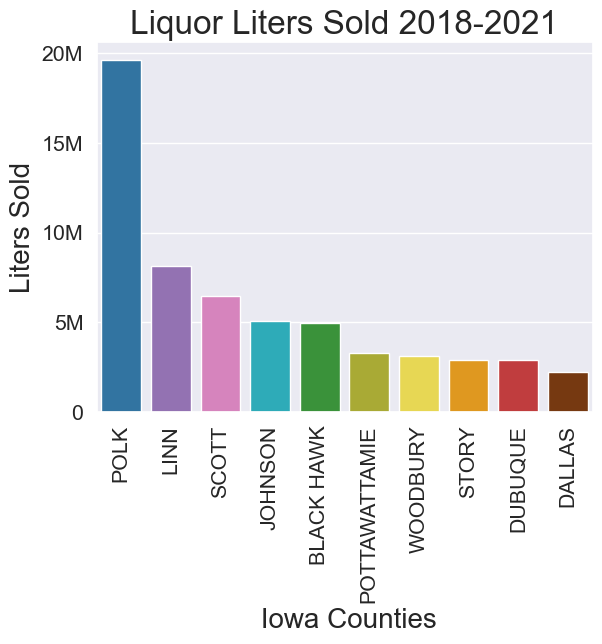

In [17]:
#sns.set_palette("tab10")
sns.barplot( x = 'county', y = 'liters_sold', data=df,  palette= county_colors)
ax = plt.gca()
# Set label for x-axis
ax.set_xlabel( " Iowa Counties" , size = 20 )
# Set label for y-axis
ax.set_ylabel("Liters Sold" , size = 20 )
  
# Set title for plot
ax.set_title( "Liquor Liters Sold 2018-2021"  , size = 24 )
#rename ax example: ax2
ax.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.xticks(rotation= 90) 
 
plt.show()

In [18]:
df2 = pd.read_csv('data/census_data.csv')

In [19]:
df3 = pd.merge(df,df2, on ='county')
df3

,liters_sold,county,population,percent_minors,income,education
0,19646575.23,POLK,492401,0.245,73015,0.38
1,8134584.43,LINN,230299,0.228,70360,0.34
2,6440681.99,SCOTT,174669,0.235,67675,0.34
3,5092119.68,JOHNSON,152854,0.197,67414,0.54
4,4972486.29,BLACK HAWK,131144,0.220,57191,0.30
5,3274895.58,POTTAWATTAMIE,93667,0.234,63840,0.23
6,3132042.70,WOODBURY,105941,0.262,63061,0.23
7,2887776.73,STORY,98537,0.164,62578,0.51
8,2867264.56,DUBUQUE,99266,0.227,68198,0.32
9,2240494.13,DALLAS,99678,0.269,93492,0.50


In [20]:
population_over_18 = df3['population']*(1-df3['percent_minors'])

df3['population_over_18'] = population_over_18
df3['population_over_18'] = df3['population_over_18'].astype(int)


liters_sold_per_adult_capita = df3['liters_sold']/df3['population_over_18']
df3['liters_sold_per_adult_capita'] = liters_sold_per_adult_capita
df3

,liters_sold,county,population,percent_minors,income,education,population_over_18,liters_sold_per_adult_capita
0,19646575.23,POLK,492401,0.245,73015,0.38,371762,52.847185
1,8134584.43,LINN,230299,0.228,70360,0.34,177790,45.753892
2,6440681.99,SCOTT,174669,0.235,67675,0.34,133621,48.201121
3,5092119.68,JOHNSON,152854,0.197,67414,0.54,122741,41.486705
4,4972486.29,BLACK HAWK,131144,0.220,57191,0.30,102292,48.610706
5,3274895.58,POTTAWATTAMIE,93667,0.234,63840,0.23,71748,45.644416
6,3132042.70,WOODBURY,105941,0.262,63061,0.23,78184,40.059893
7,2887776.73,STORY,98537,0.164,62578,0.51,82376,35.056045
8,2867264.56,DUBUQUE,99266,0.227,68198,0.32,76732,37.367260
9,2240494.13,DALLAS,99678,0.269,93492,0.50,72864,30.748986


In [21]:
#df31.style.format(thousands=',')
df31 = df3[['county','liters_sold', 'population_over_18', 'liters_sold_per_adult_capita']]

#df31.style.format(thousands=',')
df31.sort_values(by= ['population_over_18'], ascending = False)

,county,liters_sold,population_over_18,liters_sold_per_adult_capita
0,POLK,19646575.23,371762,52.847185
1,LINN,8134584.43,177790,45.753892
2,SCOTT,6440681.99,133621,48.201121
3,JOHNSON,5092119.68,122741,41.486705
4,BLACK HAWK,4972486.29,102292,48.610706
7,STORY,2887776.73,82376,35.056045
6,WOODBURY,3132042.70,78184,40.059893
8,DUBUQUE,2867264.56,76732,37.367260
9,DALLAS,2240494.13,72864,30.748986
5,POTTAWATTAMIE,3274895.58,71748,45.644416


In [22]:
df31.dtypes

county                           object
liters_sold                     float64
population_over_18                int64
liters_sold_per_adult_capita    float64
dtype: object

#### sns.set_palette("husl")
#counties = ["POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"]


sns.barplot( x = 'liters_sold_per_adult_capita', y = 'county', data=df3, palette= county_colors)
ax2 = plt.gca()
# Set label for x-axis
ax2.set_xlabel( "Liters Sold per capita (18+) (2018-2021)" , size = 20 )
  
# Set label for y-axis
ax2.set_ylabel( "Counties" , size = 20 )
ax2.set_ylabel(None, size = 20 )    
# Set title for plot
ax2.set_title( "Liquor Sales Per Capita (2018-2021)"  , size = 24 )
#rename ax example: ax2
#ax2.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 45) 
 
plt.show()

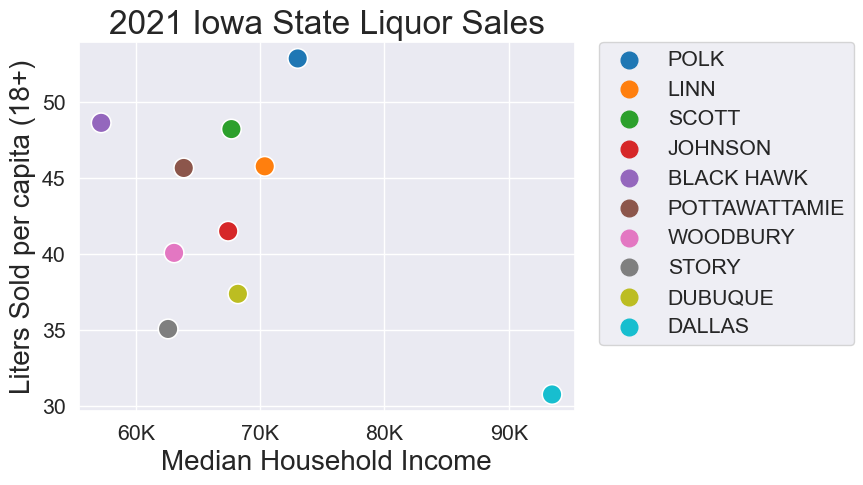

In [24]:
sns.set_palette("tab10")
sns.scatterplot( x ='income', y = 'liters_sold_per_adult_capita', data=df3, hue = 'county', s=200)
ax3 = plt.gca()
# Set label for x-axis
ax3.set_ylabel( "Liters Sold per capita (18+)" , size = 20 )
  
# Set label for y-axis
ax3.set_xlabel( "Median Household Income" , size = 20 )
    
# Set title for plot
ax3.set_title( "2021 Iowa State Liquor Sales"  , size = 24 )
#rename ax example: ax2
ax3.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 45) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)

"""
#attempt to label points with county
cap = list(df3.county)
for i, 'liters_sold' in enumerate(cap):
    plt.text(i, 'liters_sold', s= 'county')
"""

plt.show()

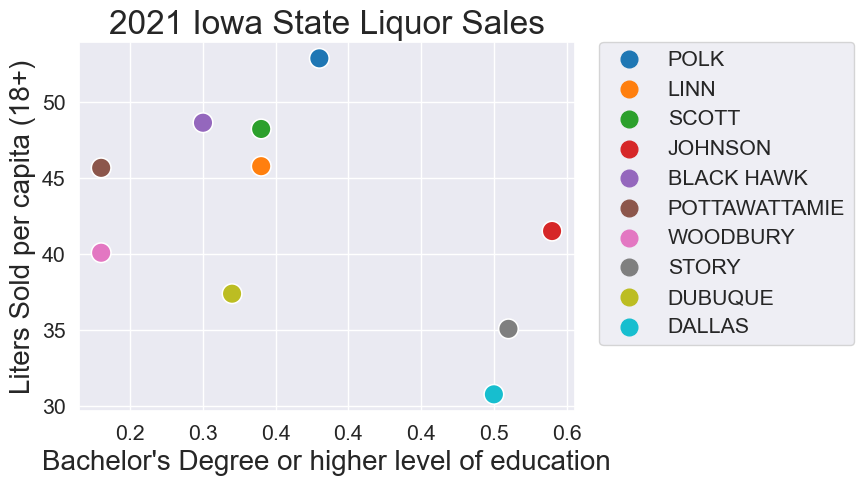

In [25]:
sns.set_palette("tab10")
sns.scatterplot( x ='education', y = 'liters_sold_per_adult_capita', data=df3,  hue = 'county', s=200)
ax4 = plt.gca()
# Set label for x-axis
ax4.set_ylabel( "Liters Sold per capita (18+)" , size = 20 )
  
# Set label for x-axis
ax4.set_xlabel( "Bachelor's Degree or higher level of education" , size = 20 )
    
# Set title for plot
ax4.set_title( "2021 Iowa State Liquor Sales"  , size = 24 )
#rename ax example: ax2
ax4.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 45) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)
#plt.text(s= 'county')



plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


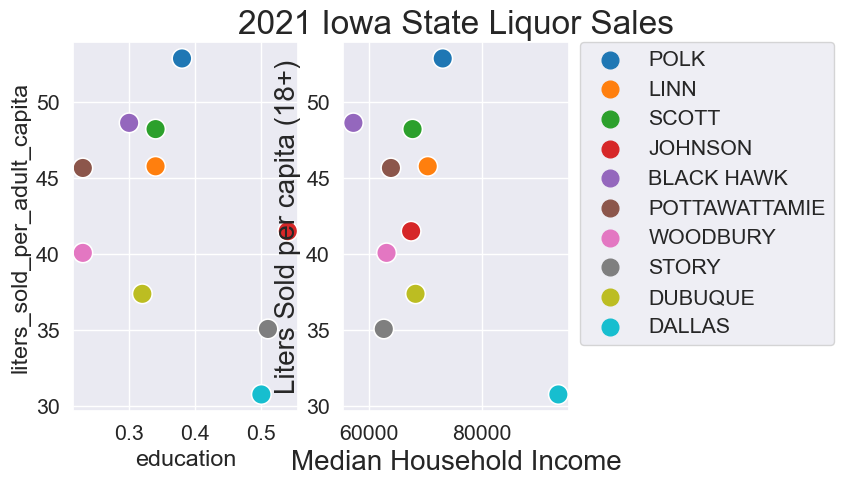

In [26]:
fig, axes = plt.subplots(1,2)
sns.scatterplot( x ='education', y = 'liters_sold_per_adult_capita', data=df3, ax=axes[0], legend = False, hue = 'county', s=200)
ax4 = plt.gca()
ax4.set_ylabel( "Liters Sold per capita (18+)" , size = 20 )
ax4.set_xlabel( "Bachelor's Degree or higher level of education" , size = 20 )
ax4.set_title( "2021 Iowa State Liquor Sales", size = 24 )
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)
#plt.text(s= 'county')

sns.set_palette("tab10")
sns.scatterplot( x ='income', y = 'liters_sold_per_adult_capita', data=df3, ax=axes[1], hue = 'county', s=200)
ax3 = plt.gca()
ax3.set_ylabel( "Liters Sold per capita (18+)" , size = 20 )
ax3.set_xlabel( "Median Household Income" , size = 20 )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)

In [27]:
cat_sql_statement = """
with source_table AS(
  SELECT
  volume_sold_liters,
  county,
 IF (county ='POTTAWATTA','POTTAWATTAMIE', county),
item_description,
category_name
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) = 2021 AND county IN ("POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","WOODBURY","DUBUQUE","STORY","DALLAS","POTTAWATTA")
),

liquor_categories AS 
  (SELECT
  volume_sold_liters,
  county,
  CASE 
WHEN category_name LIKE '%AMAR%' OR category_name LIKE '%CREME%'OR category_name LIKE '%LIQUEUR%' OR category_name LIKE '%CORDIAL%' OR category_name LIKE '%ANIS%' OR category_name LIKE '%TRIPLE SEC%' OR item_description LIKE '%JAGERM%' OR item_description LIKE '%LIQUEUR%' OR item_description LIKE '%SAINTS N SINNERS APPLE PIE%' THEN 'LIQUEUR' 
  WHEN category_name LIKE '%WHIS%' OR category_name LIKE '%BOUR%'OR category_name LIKE '%RYE%' OR item_description LIKE '%RYE%' OR item_description LIKE '%WHIS%'OR item_description LIKE '%SCOTCH%' OR category_name LIKE '%SCOTCH%' OR item_description LIKE '%BEAM%' OR item_description LIKE '%BOUR%' OR item_description LIKE '%CROWN ROYAL%' OR item_description LIKE '%JACK DAN%'OR item_description LIKE '%EVAN WILL%'OR item_description LIKE '%MAKER%MARK%' OR item_description LIKE '%SIR WINSTON%' OR item_description LIKE '%ELIJAH%' OR item_description LIKE '%JOHNNIE WALKER%'THEN 'WHISKEY'
  WHEN category_name LIKE '%VOD%' OR item_description LIKE '%VOD%'OR item_description LIKE '%SMIRN%'THEN 'VODKA'
  WHEN category_name LIKE '%BRANDI%' OR category_name LIKE '%BRANDY%' OR category_name LIKE '%SCHNAPPS%' OR item_description LIKE '%COGNAC%' OR item_description LIKE '%HENNESSY%'THEN 'BRANDY'
  WHEN category_name LIKE '%RUM%' OR item_description LIKE '%RUM%' OR item_description LIKE '%CAPTAIN MOR%'THEN 'RUM'
  WHEN category_name LIKE '%TEQ%' OR category_name LIKE '%MEZC%' OR item_description LIKE '%JUAREZ%' OR item_description LIKE '%TEQU%' OR item_description LIKE '%REPOSADO%' OR item_description LIKE '%TORTILLA GOLD%' OR item_description LIKE '%MONTEZUMA%' THEN 'TEQUILA AND MEZCAL'
  WHEN category_name LIKE '%GIN%' OR item_description LIKE '%GIN%' THEN 'GIN'

  WHEN category_name LIKE '%COCKT%' OR item_description LIKE '%TARANTULA%' THEN 'COCKTAILS_RTD'
  ELSE 'OTHER' END AS LIQUOR_TYPE
  FROM source_table)

SELECT  
  LIQUOR_TYPE,
 county,
sum(volume_sold_liters) AS liters_sold_per_cat
FROM liquor_categories
WHERE county = "POLK"
GROUP BY LIQUOR_TYPE, county
""" .strip()

In [28]:
df4 = pd.read_sql_query(cat_sql_statement, engine)
df4

,LIQUOR_TYPE,county,liters_sold_per_cat
0,VODKA,POLK,1715823.80
1,COCKTAILS_RTD,POLK,209292.97
2,TEQUILA AND MEZCAL,POLK,448496.88
3,LIQUEUR,POLK,563626.91
4,GIN,POLK,137239.23
5,RUM,POLK,530955.85
6,OTHER,POLK,43251.83
7,BRANDY,POLK,302086.06
8,WHISKEY,POLK,1254245.29


In [29]:
df4['LIQUOR_TYPE']

0                 VODKA
1         COCKTAILS_RTD
2    TEQUILA AND MEZCAL
3               LIQUEUR
4                   GIN
5                   RUM
6                 OTHER
7                BRANDY
8               WHISKEY
Name: LIQUOR_TYPE, dtype: object

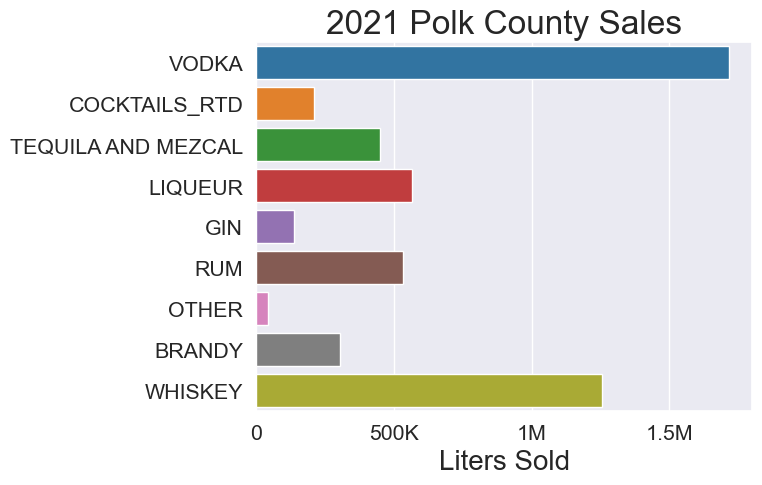

In [30]:
sns.set_palette("tab10")
sns.barplot( x = 'liters_sold_per_cat', y = 'LIQUOR_TYPE', data=df4)
ax4  = plt.gca()
  
# Set label for x-axis
ax4.set_xlabel("Liters Sold" , size = 20 )

# Set label for y-axis

#ax4.set_ylabel("Liquor Type" , size = 20 )
ax4.set(ylabel=None)
    
# Set title for plot
ax4.set_title( "2021 Polk County Sales", size = 24 )
#rename ax example: ax2
ax4.xaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 90) 
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)
#plt.text(s= 'county')
plt.show()

In [31]:
cat_year_sql_statement = """
with source_table AS(
  SELECT
  volume_sold_liters,
  CAST(EXTRACT(YEAR FROM date) AS string) as year,
item_description,
category_name
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018,2019,2020,2021) AND county = "POLK"),

liquor_categories AS 
  (SELECT
  volume_sold_liters,
year,
  CASE 
    WHEN category_name LIKE '%AMAR%' OR category_name LIKE '%CREME%'OR category_name LIKE '%LIQUEUR%' OR category_name LIKE '%CORDIAL%' OR category_name LIKE '%ANIS%' OR category_name LIKE '%TRIPLE SEC%' OR item_description LIKE '%JAGERM%' OR item_description LIKE '%LIQUEUR%' OR item_description LIKE '%SAINTS N SINNERS APPLE PIE%' THEN 'LIQUEUR' 
  WHEN category_name LIKE '%WHIS%' OR category_name LIKE '%BOUR%'OR category_name LIKE '%RYE%' OR item_description LIKE '%RYE%' OR item_description LIKE '%WHIS%'OR item_description LIKE '%SCOTCH%' OR category_name LIKE '%SCOTCH%' OR item_description LIKE '%BEAM%' OR item_description LIKE '%BOUR%' OR item_description LIKE '%CROWN ROYAL%' OR item_description LIKE '%JACK DAN%'OR item_description LIKE '%EVAN WILL%'OR item_description LIKE '%MAKER%MARK%' OR item_description LIKE '%SIR WINSTON%' OR item_description LIKE '%ELIJAH%' OR item_description LIKE '%JOHNNIE WALKER%'THEN 'WHISKEY'
  WHEN category_name LIKE '%VOD%' OR item_description LIKE '%VOD%'OR item_description LIKE '%SMIRN%'THEN 'VODKA'
  WHEN category_name LIKE '%BRANDI%' OR category_name LIKE '%BRANDY%' OR category_name LIKE '%SCHNAPPS%' OR item_description LIKE '%COGNAC%' OR item_description LIKE '%HENNESSY%'THEN 'BRANDY'
  WHEN category_name LIKE '%RUM%' OR item_description LIKE '%RUM%' OR item_description LIKE '%CAPTAIN MOR%'THEN 'RUM'
  WHEN category_name LIKE '%TEQ%' OR category_name LIKE '%MEZC%' OR item_description LIKE '%JUAREZ%' OR item_description LIKE '%TEQU%' OR item_description LIKE '%REPOSADO%' OR item_description LIKE '%TORTILLA GOLD%' OR item_description LIKE '%MONTEZUMA%' THEN 'TEQUILA AND MEZCAL'
  WHEN category_name LIKE '%GIN%' OR item_description LIKE '%GIN%' THEN 'GIN'

  WHEN category_name LIKE '%COCKT%' OR item_description LIKE '%TARANTULA%' THEN 'COCKTAILS_RTD'
  ELSE 'OTHER' END AS LIQUOR_TYPE
  FROM source_table)

SELECT  
  LIQUOR_TYPE,
year,
sum(volume_sold_liters) AS liters_sold_per_cat
FROM liquor_categories

GROUP BY LIQUOR_TYPE, year
ORDER BY year 

""" .strip()

In [32]:
df5 = pd.read_sql_query(cat_year_sql_statement, engine)

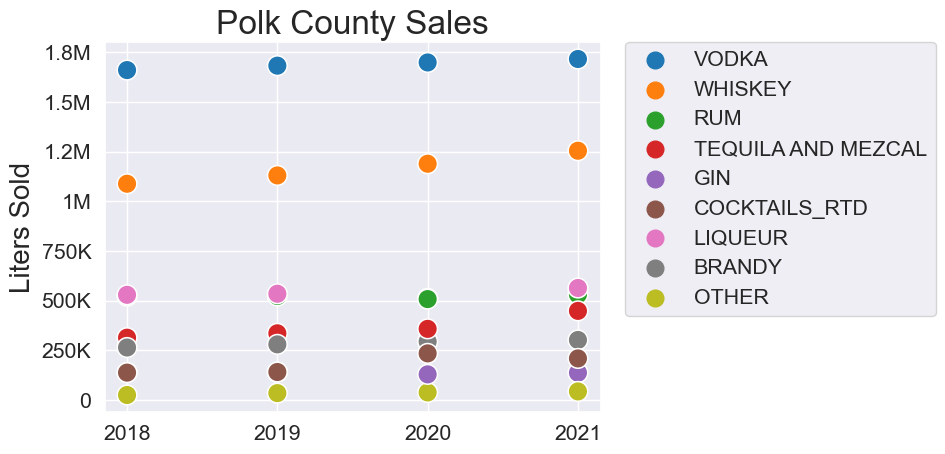

In [33]:
sns.set_palette("tab10")
sns.scatterplot( x = 'year', y = 'liters_sold_per_cat', data=df5, hue = 'LIQUOR_TYPE', s=200, hue_order = ["VODKA", "WHISKEY", "RUM", "TEQUILA AND MEZCAL", "GIN",  "COCKTAILS_RTD",  "LIQUEUR", "BRANDY", "OTHER" ])
ax5  = plt.gca()
  
# Set label for x-axis
#ax5.set_xlabel("year" , size = 20 )
ax5.set(xlabel=None)
# Set label for y-axis

ax5.set_ylabel("Liters Sold" , size = 20 )
#ax5.set(ylabel=None)
    
# Set title for plot
ax5.set_title( "Polk County Sales", size = 24 )
#rename ax example: ax2
ax5.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 90) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)
#plt.text(s= 'county')

#set the ticks first
#ax5.set_xticks(range([6])
  
# set the labels
#ax5.set_xticklabels(['2017','2018', '2019', '2020', '2021', '2022'])

In [34]:
#calculate percent change column from previous year using window function OR Python, maybe numpy?


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


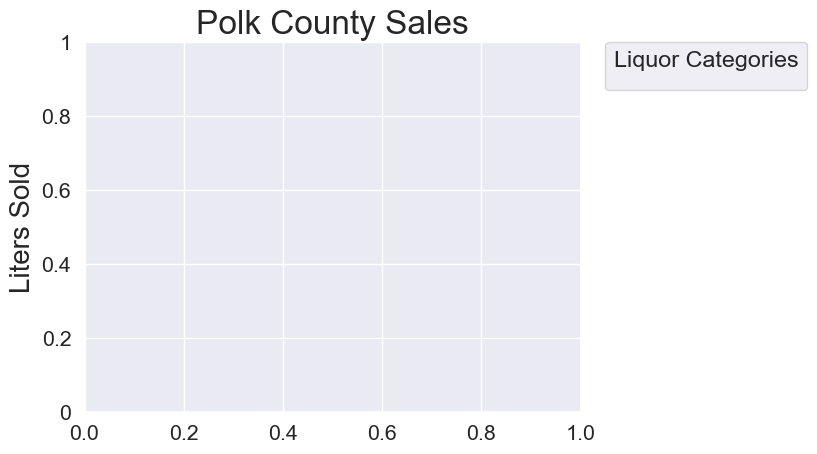

In [35]:
sns.set_palette("tab10")

#df5.plot.bar( stacked = True, x = 'year',  color = sns.color_palette('Set2'))
ax5  = plt.gca()
  
# Set label for x-axis
#ax5.set_xlabel("year" , size = 20 )
ax5.set(xlabel=None)
# Set label for y-axis

ax5.set_ylabel("Liters Sold" , size = 20 )
#ax5.set(ylabel=None)
    
# Set title for plot
ax5.set_title( "Polk County Sales", size = 24 )
#rename ax example: ax2
ax5.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 90) 
plt.legend(bbox_to_anchor=(1.05, 1),title='Liquor Categories', loc='upper left',  borderaxespad=0, markerscale=2)
#plt.legend(title='Smoker', loc='upper left', labels=['Hell Yeh', 'Nah Bruh'])
#plt.text(s= 'county')

#set the ticks first
#ax5.set_xticks(range([6])
  
# set the labels
#ax5.set_xticklabels(['2017','2018', '2019', '2020', '2021', '2022'])

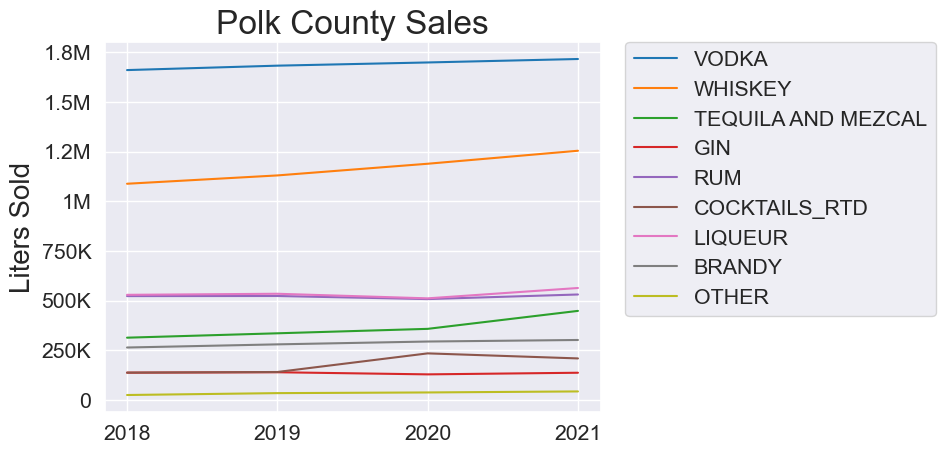

In [36]:
sns.set_palette("tab10")
sns.lineplot(data = df5, x = 'year', y = 'liters_sold_per_cat', hue= 'LIQUOR_TYPE', hue_order = ["VODKA", "WHISKEY", "TEQUILA AND MEZCAL","GIN", "RUM", "COCKTAILS_RTD",  "LIQUEUR", "BRANDY", "OTHER" ])
#df5.plot.bar( stacked = True, x = 'year',  color = sns.color_palette('Set2'))
ax5  = plt.gca()
  
# Set label for x- 
#ax5.set_xlabel("year" , size = 20 )
ax5.set(xlabel=None)
# Set label for y-axis

ax5.set_ylabel("Liters Sold" , size = 20 )
#ax5.set(ylabel=None)
    
# Set title for plot
ax5.set_title( "Polk County Sales", size = 24 )
#rename ax example: ax2
ax5.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 90) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)
#plt.text(s= 'county')

#set the ticks first
#ax5.set_xticks(range([6])
  
# set the labels
#ax5.set_xticklabels(['2017','2018', '2019', '2020', '2021', '2022'])

In [37]:
all_county_all_year = """

  SELECT
  sum(volume_sold_liters) AS liters_sold,
 CAST(EXTRACT(YEAR FROM date) AS string) as year,
 IF (county ='POTTAWATTA','POTTAWATTAMIE', county) AS county
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020,2021) AND county IN ("POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","WOODBURY","DUBUQUE","STORY","DALLAS","POTTAWATTA")
GROUP BY county, year 
ORDER BY year

""" .strip()

In [53]:
df6 = pd.read_sql_query(all_county_all_year, engine)


In [39]:
df6.dtypes

liters_sold    float64
year            object
county          object
dtype: object

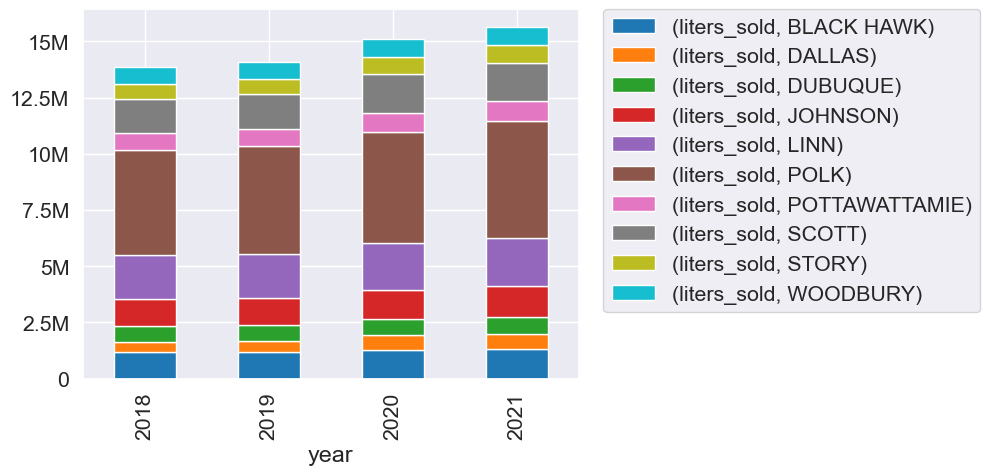

In [52]:
df6.groupby(['year', 'county']).sum('liters_sold').unstack().plot(kind='bar', stacked=True)
ax41 = plt.gca()
ax41.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.show()

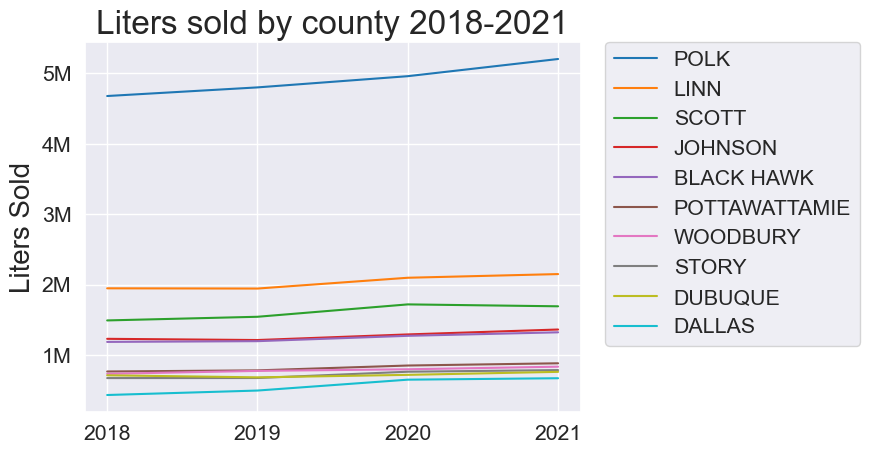

In [40]:
#sns.set_palette("tab10")
sns.lineplot(data = df6, x = 'year', y = 'liters_sold', hue= 'county', 
hue_order = [
    "POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"
         ])
                         

#df5.plot.bar( stacked = True, x = 'year',  color = sns.color_palette('Set2'))
ax5  = plt.gca()
  
# Set label for x- 
#ax5.set_xlabel("year" , size = 20 )
ax5.set(xlabel=None)
# Set label for y-axis

ax5.set_ylabel("Liters Sold" , size = 20 )
#ax5.set(ylabel=None)


# Set title for plot
ax5.set_title( "Liters sold by county 2018-2021", size = 24 )
#rename ax example: ax2
ax5.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 90) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)
#plt.text(s= 'county')
#ax5.add_legend(label_order = ["VODKA", "WHISKEY", "TEQUILA AND MEZCAL","GIN", "RUM", "COCKTAILS_RTD",  "LIQUEUR", "BRANDY", "OTHER" ])

#set the ticks first
#ax5.set_xticks(range([6])
  
# set the labels
#ax5.set_xticks(range(len(df6))) # <--- set the ticks first

#ax5.set_xticklabels(['2017','2018', '2019', '2020', '2021', '2022'])

In [41]:
cat_month_year_sql_statement = """ 
with source_table AS(
  SELECT
  EXTRACT(YEAR FROM date) AS year,
   EXTRACT(MONTH FROM date) AS month,
  category_name, item_description,
  volume_sold_liters,
  date
  #,
 #IF (county ='POTTAWATTA','POTTAWATTAMIE', county)
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  #WHERE county IN ("POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","WOODBURY","DUBUQUE","STORY","DALLAS","POTTAWATTA")
),

liquor_categories AS 
  (SELECT
  volume_sold_liters,
year, month,
  CASE
    WHEN category_name LIKE '%AMAR%' OR category_name LIKE '%CREME%'OR category_name LIKE '%LIQUEUR%' OR category_name LIKE '%CORDIAL%' OR category_name LIKE '%ANIS%' OR category_name LIKE '%TRIPLE SEC%' OR item_description LIKE '%JAGERM%' OR item_description LIKE '%LIQUEUR%' OR item_description LIKE '%SAINTS N SINNERS APPLE PIE%' THEN 'LIQUEUR' 
  WHEN category_name LIKE '%WHIS%' OR category_name LIKE '%BOUR%'OR category_name LIKE '%RYE%' OR item_description LIKE '%RYE%' OR item_description LIKE '%WHIS%'OR item_description LIKE '%SCOTCH%' OR category_name LIKE '%SCOTCH%' OR item_description LIKE '%BEAM%' OR item_description LIKE '%BOUR%' OR item_description LIKE '%CROWN ROYAL%' OR item_description LIKE '%JACK DAN%'OR item_description LIKE '%EVAN WILL%'OR item_description LIKE '%MAKER%MARK%' OR item_description LIKE '%SIR WINSTON%' OR item_description LIKE '%ELIJAH%' OR item_description LIKE '%JOHNNIE WALKER%'THEN 'WHISKEY'
  WHEN category_name LIKE '%VOD%' OR item_description LIKE '%VOD%'OR item_description LIKE '%SMIRN%'THEN 'VODKA'
  WHEN category_name LIKE '%BRANDI%' OR category_name LIKE '%BRANDY%' OR category_name LIKE '%SCHNAPPS%' OR item_description LIKE '%COGNAC%' OR item_description LIKE '%HENNESSY%'THEN 'BRANDY'
  WHEN category_name LIKE '%RUM%' OR item_description LIKE '%RUM%' OR item_description LIKE '%CAPTAIN MOR%'THEN 'RUM'
  WHEN category_name LIKE '%TEQ%' OR category_name LIKE '%MEZC%' OR item_description LIKE '%JUAREZ%' OR item_description LIKE '%TEQU%' OR item_description LIKE '%REPOSADO%' OR item_description LIKE '%TORTILLA GOLD%' OR item_description LIKE '%MONTEZUMA%' THEN 'TEQUILA AND MEZCAL'
  WHEN category_name LIKE '%GIN%' OR item_description LIKE '%GIN%' THEN 'GIN'

  WHEN category_name LIKE '%COCKT%' OR item_description LIKE '%TARANTULA%' THEN 'COCKTAILS_RTD'
  ELSE 'OTHER' END AS LIQUOR_TYPE
  FROM source_table)

SELECT ROUND(SUM(volume_sold_liters)) AS liters_sold, year, month, LIQUOR_TYPE
FROM liquor_categories
WHERE year IN (2018,2019,2020,2021)
GROUP BY year, month, LIQUOR_TYPE
ORDER BY month, year

   """ .strip()

In [42]:
df61 = pd.read_sql_query(cat_month_year_sql_statement, engine)
df61['Date'] = pd.to_datetime(df61.assign(Day=1).loc[:, ['year','month','Day']])

df61

,liters_sold,year,month,LIQUOR_TYPE,Date
0,34581.0,2018,1,COCKTAILS_RTD,2018-01-01
1,71005.0,2018,1,TEQUILA AND MEZCAL,2018-01-01
2,6630.0,2018,1,OTHER,2018-01-01
3,193319.0,2018,1,RUM,2018-01-01
4,402187.0,2018,1,WHISKEY,2018-01-01
...,...,...,...,...,...
427,54052.0,2021,12,GIN,2021-12-01
428,637739.0,2021,12,VODKA,2021-12-01
429,291223.0,2021,12,RUM,2021-12-01
430,85815.0,2021,12,COCKTAILS_RTD,2021-12-01


(array([17532., 17713., 17897., 18078., 18262., 18444., 18628., 18809.,
        18993.]),
 [Text(17532.0, 0, '2018-01'),
  Text(17713.0, 0, '2018-07'),
  Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01')])

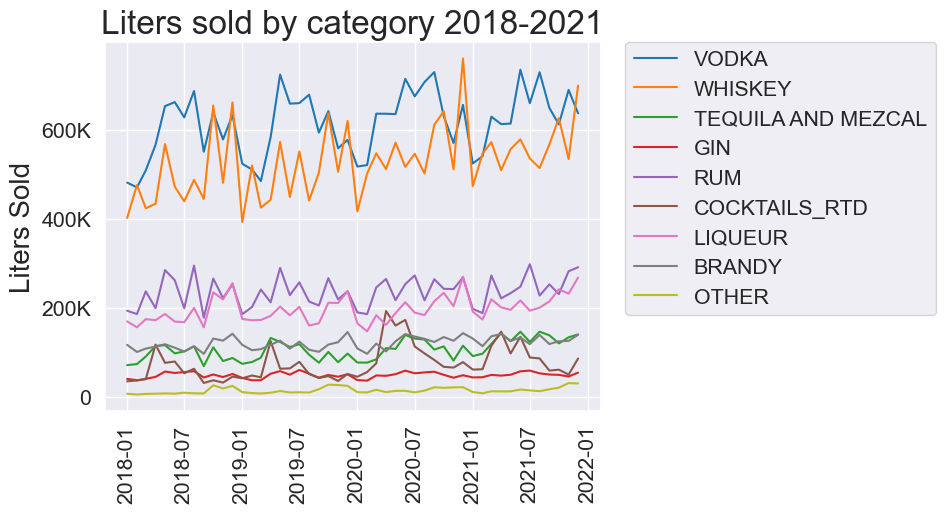

In [43]:
sns.set_palette("tab10")
sns.lineplot(data = df61, x = 'Date', y = 'liters_sold', hue= 'LIQUOR_TYPE', hue_order = ["VODKA", "WHISKEY", "TEQUILA AND MEZCAL","GIN", "RUM", "COCKTAILS_RTD",  "LIQUEUR", "BRANDY", "OTHER" ])

#df5.plot.bar( stacked = True, x = 'year',  color = sns.color_palette('Set2'))
ax5  = plt.gca()
  
# Set label for x- 
#ax5.set_xlabel("year" , size = 20 )
ax5.set(xlabel=None)
# Set label for y-axis

ax5.set_ylabel("Liters Sold" , size = 20 )
#ax5.set(ylabel=None)


# Set title for plot
ax5.set_title( "Liters sold by category 2018-2021", size = 24 )
#rename ax example: ax2
ax5.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 90) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)
plt.xticks(rotation= 90) 

In [44]:
liter_sold_per_cat_lag_year_sql_statement = """
WITH source_table AS(
  SELECT
    volume_sold_liters,
    CAST(EXTRACT(YEAR FROM date) AS string) AS year,
    item_description,
    category_name
  FROM
    `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE
    EXTRACT(YEAR
    FROM
      date) IN (2017,2018,2019,2020,2021)),
  
  liquor_categories AS (
  SELECT
    volume_sold_liters,
    year,
    CASE
     WHEN category_name LIKE '%AMAR%' OR category_name LIKE '%CREME%'OR category_name LIKE '%LIQUEUR%' OR category_name LIKE '%CORDIAL%' OR category_name LIKE '%ANIS%' OR category_name LIKE '%TRIPLE SEC%' OR item_description LIKE '%JAGERM%' OR item_description LIKE '%LIQUEUR%' OR item_description LIKE '%SAINTS N SINNERS APPLE PIE%' THEN 'LIQUEUR'
      WHEN category_name LIKE '%WHIS%' OR category_name LIKE '%BOUR%'OR category_name LIKE '%RYE%' OR item_description LIKE '%RYE%' OR item_description LIKE '%WHIS%'OR item_description LIKE '%SCOTCH%' OR category_name LIKE '%SCOTCH%' OR item_description LIKE '%BEAM%' OR item_description LIKE '%BOUR%' OR item_description LIKE '%CROWN ROYAL%' OR item_description LIKE '%JACK DAN%'OR item_description LIKE '%EVAN WILL%'OR item_description LIKE '%MAKER%MARK%' OR item_description LIKE '%SIR WINSTON%' OR item_description LIKE '%ELIJAH%' OR item_description LIKE '%JOHNNIE WALKER%'THEN 'WHISKEY'
      WHEN category_name LIKE '%VOD%'
    OR item_description LIKE '%VOD%'OR item_description LIKE '%SMIRN%'THEN 'VODKA'
      WHEN category_name LIKE '%BRANDI%' OR category_name LIKE '%BRANDY%' OR category_name LIKE '%SCHNAPPS%' OR item_description LIKE '%COGNAC%' OR item_description LIKE '%HENNESSY%'THEN 'BRANDY'
      WHEN category_name LIKE '%RUM%'
    OR item_description LIKE '%RUM%'
    OR item_description LIKE '%CAPTAIN MOR%'THEN 'RUM'
      WHEN category_name LIKE '%TEQ%' OR category_name LIKE '%MEZC%' OR item_description LIKE '%JUAREZ%' OR item_description LIKE '%TEQU%' OR item_description LIKE '%REPOSADO%' OR item_description LIKE '%TORTILLA GOLD%' OR item_description LIKE '%MONTEZUMA%' THEN 'TEQUILA AND MEZCAL'
      WHEN category_name LIKE '%GIN%'
    OR item_description LIKE '%GIN%' THEN 'GIN'
     
      WHEN category_name LIKE '%COCKT%'
    OR item_description LIKE '%TARANTULA%' THEN 'COCKTAILS_RTD'
    ELSE
    'OTHER' END AS LIQUOR_TYPE
  FROM
    source_table),
  
  liters_cat_sum AS (
  SELECT
    LIQUOR_TYPE,
    year,
    SUM(volume_sold_liters) AS liters_sold_per_cat
  FROM
    liquor_categories
  GROUP BY
    LIQUOR_TYPE,
    year),

  liters_cat_year_sum AS (
  SELECT
    LIQUOR_TYPE,
    year,
    liters_sold_per_cat,
    LAG(liters_sold_per_cat) OVER(PARTITION BY LIQUOR_TYPE ORDER BY year) AS prev_liter_sold_per_cat
  FROM
    liters_cat_sum),

percent_change_per_year AS (
SELECT  
  LIQUOR_TYPE,
  year,
  ROUND(((liters_sold_per_cat - prev_liter_sold_per_cat)/liters_sold_per_cat)*100) AS percent_change_year

FROM liters_cat_year_sum)


SELECT
  *
FROM
percent_change_per_year
  
ORDER BY
  year,
  LIQUOR_TYPE
  
""" .strip()

In [45]:
df7 = pd.read_sql_query(liter_sold_per_cat_lag_year_sql_statement, engine)

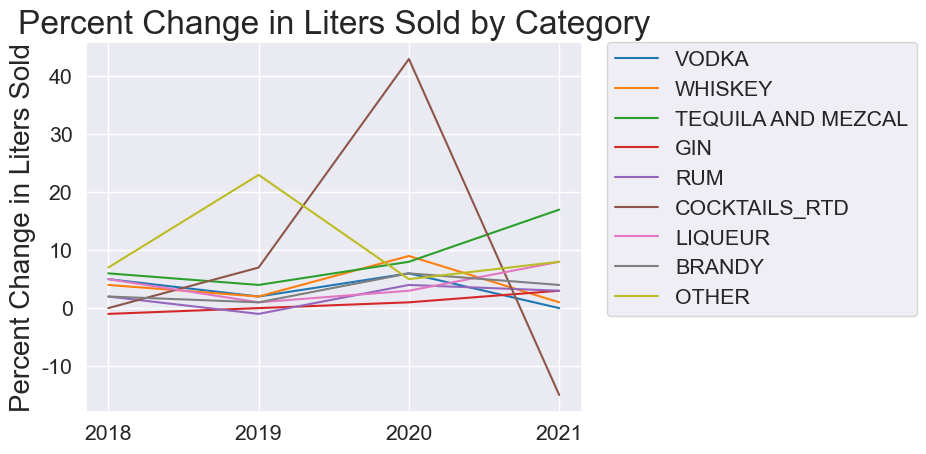

In [46]:
sns.set_palette("tab10")
sns.lineplot(data = df7, x = 'year', y = 'percent_change_year', hue= 'LIQUOR_TYPE', hue_order = ["VODKA", "WHISKEY", "TEQUILA AND MEZCAL","GIN", "RUM", "COCKTAILS_RTD",  "LIQUEUR", "BRANDY", "OTHER" ])

#df5.plot.bar( stacked = True, x = 'year',  color = sns.color_palette('Set2'))
ax5  = plt.gca()
  
# Set label for x- 
#ax5.set_xlabel("year" , size = 20 )
ax5.set(xlabel=None)
# Set label for y-axis

ax5.set_ylabel("Percent Change in Liters Sold" , size = 20 )
# Set title for plot
ax5.set_title( "Percent Change in Liters Sold by Category", size = 24 )
#rename ax example: ax2
ax5.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 90) 
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, markerscale=2)

In [64]:
percent_change_county = """
WITH source_table AS(
  SELECT
    volume_sold_liters,
    CAST(EXTRACT(YEAR FROM date) AS string) AS year,
    IF (county ='POTTAWATTA','POTTAWATTAMIE', county) AS county
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE county IN ("POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","WOODBURY","DUBUQUE","STORY","DALLAS","POTTAWATTA")
             AND EXTRACT(YEAR FROM date) IN (2017,2018,2019,2020,2021)),

  liters_county_sum AS (
    SELECT 
        SUM(volume_sold_liters) as liters_sold_county,
        year,
        county
    FROM source_table
    GROUP BY year, county),
  
lag_year AS(
    SELECT
      county,
      year,
      liters_sold_county,
        LAG(liters_sold_county) OVER(PARTITION BY county ORDER BY year) AS prev_liters_sold_county
      FROM
        liters_county_sum),

percent_change_per_year AS (
SELECT  
  county,
  year,
  ROUND(((liters_sold_county - prev_liters_sold_county)/liters_sold_county)*100) AS percent_change_year
FROM lag_year)

SELECT
  *
FROM
percent_change_per_year
ORDER BY
  year,
  county
  
""" .strip()

In [65]:
df8 = pd.read_sql_query(percent_change_county, engine)

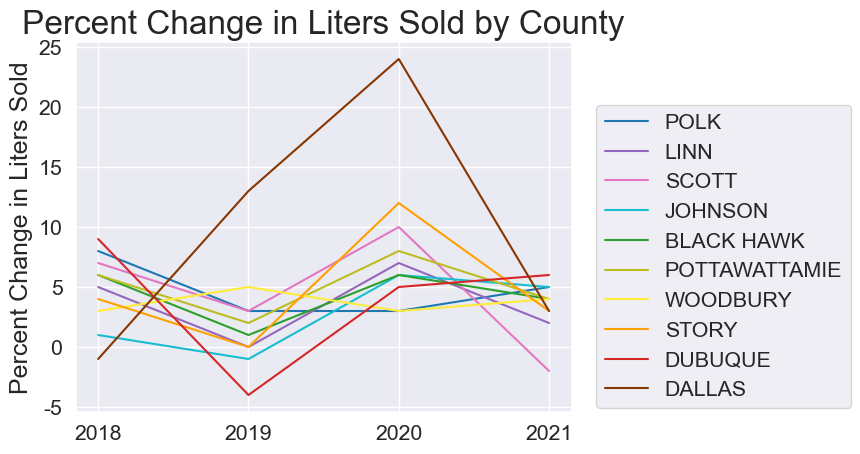

In [66]:
#sns.set_palette("tab10")
sns.lineplot(data = df8, x = 'year', y = 'percent_change_year', hue= 'county',  palette= county_colors,
            hue_order = ["POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"
         ])

#df5.plot.bar( stacked = True, x = 'year',  color = sns.color_palette('Set2'))
ax6= plt.gca()
  
# Set label for x- 
#ax5.set_xlabel("year" , size = 20 )
ax6.set(xlabel=None)
# Set label for y-axis
ax6.set_ylabel("Percent Change in Liters Sold" , size = 18 )
# Set title for plot
ax6.set_title( "Percent Change in Liters Sold by County", size = 24 )
#rename ax example: ax2
ax6.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
#plt.xticks(rotation= 90) 
plt.legend(bbox_to_anchor=(1.05, .83), loc='upper left', borderaxespad=0, markerscale=2)

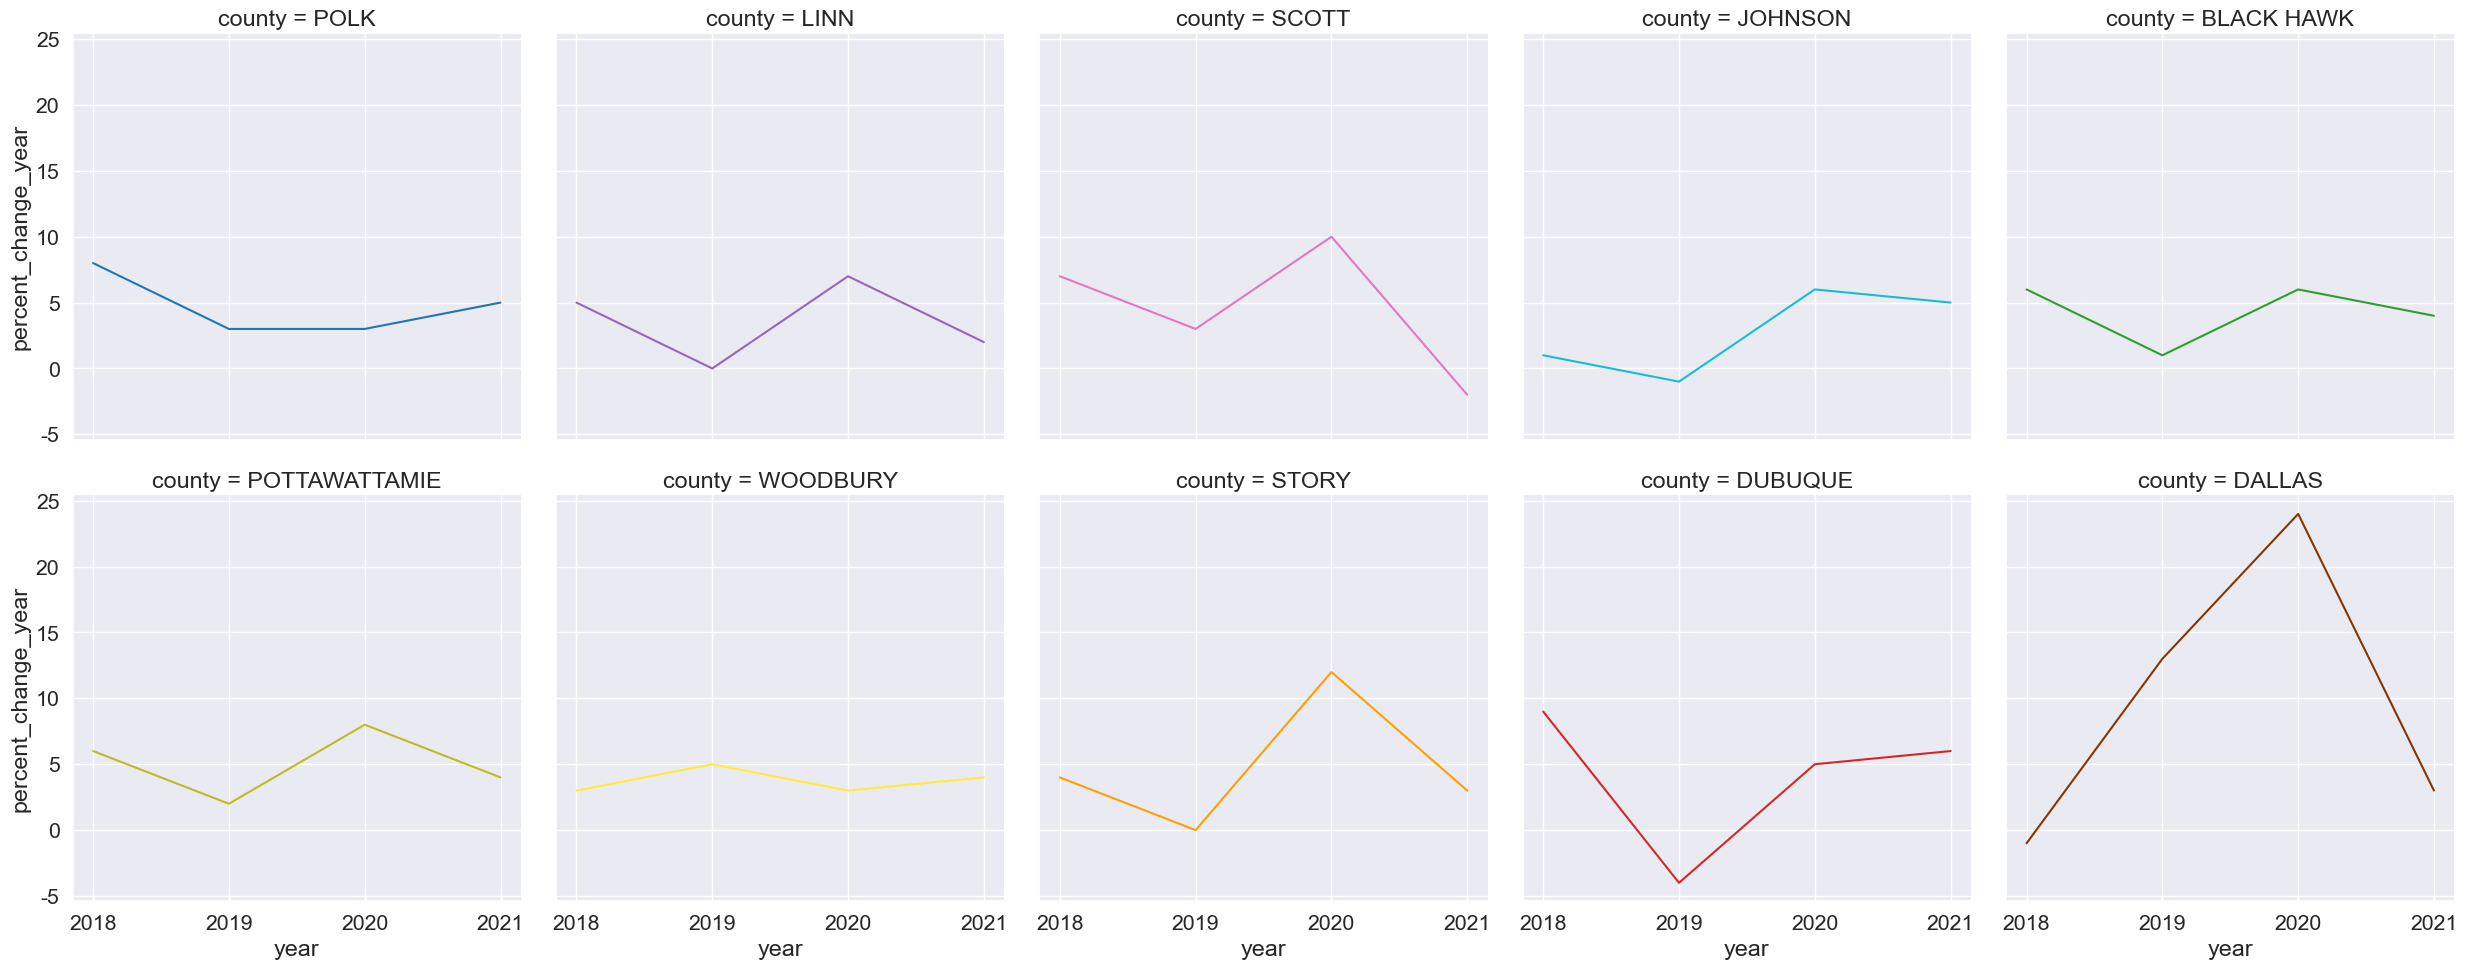

In [71]:
#data = df8, x = 'year', y = 'percent_change_year', hue= 'county',  palette= county_colors,
 #           hue_order = ["POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"
         

sns.relplot(legend = None, kind = 'line', data = df8,x = 'year', y = 'percent_change_year', hue= 'county', col_wrap = 5, col = 'county',  palette= county_colors,
            hue_order = ["POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"],  col_order = ["POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"])
ax6= plt.gca()
ax6.set(xlabel= 'year')
ax6.set_ylabel("Percent Change in Liters Sold" , size = 18 )
#ax6.set_title( "Percent Change in Liters Sold by County", size = 24 )
ax6.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values)) 
#plt.legend(bbox_to_anchor=(1.05, .83), loc='upper left', borderaxespad=0, markerscale=2)
#plt.xticks(rotation= 90) 
plt.show()

In [56]:
percent_change_county_month_year = """
WITH
  source_table AS(
  SELECT
    volume_sold_liters,
    date,
    CAST(EXTRACT(YEAR
      FROM
        date) AS string) AS year,
    FORMAT_DATE('%b %Y', date ) AS date_formatted,
  IF
    (county ='POTTAWATTA','POTTAWATTAMIE', county) AS county
  FROM
    `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE
    county IN ("POLK",
      "LINN",
      "SCOTT",
      "JOHNSON",
      "BLACK HAWK",
      "WOODBURY",
      "DUBUQUE",
      "STORY",
      "DALLAS",
      "POTTAWATTA")
    AND EXTRACT(YEAR
    FROM
      date) IN (2017,
      2018,
      2019,
      2020,
      2021)),
  liters_county_sum AS (
  SELECT
    SUM(volume_sold_liters) AS liters_sold_county,
    MIN(date) as date,
    year,
    date_formatted,
    county
  FROM
    source_table
  GROUP BY
    year,
    date_formatted,
    county),
  lag_year AS(
  SELECT
    county,
    date,
    year,
    date_formatted,
    liters_sold_county,
    LAG(liters_sold_county) OVER(PARTITION BY county ORDER BY date) AS prev_liters_sold_county
  FROM
    liters_county_sum),
  percent_change_per_year AS (
  SELECT
    county,
    date,
    date_formatted,
    year,
    ROUND(((liters_sold_county - prev_liters_sold_county)/liters_sold_county)*100) AS percent_change_year
  FROM
    lag_year)
SELECT
  *
FROM
  percent_change_per_year
  WHERE year <> '2017'
ORDER BY
  date,
  county
  """ .strip()

In [57]:
df9 = pd.read_sql_query(percent_change_county_month_year, engine)

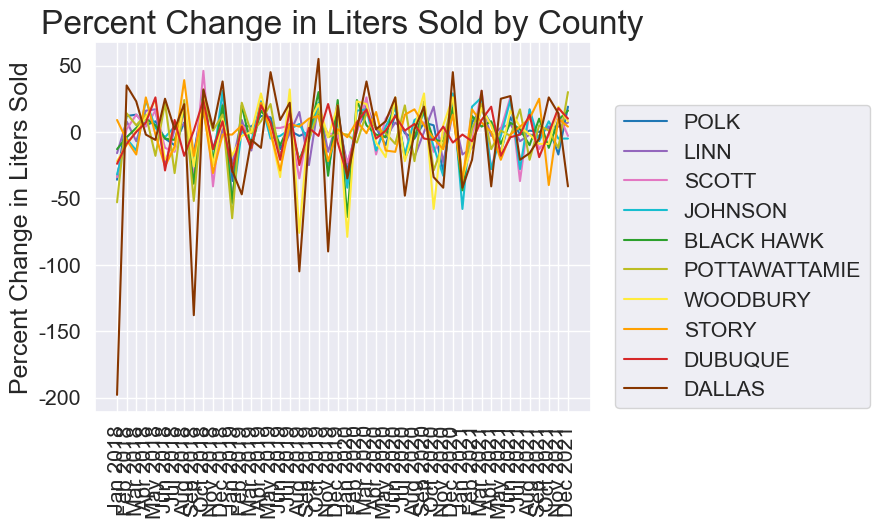

In [58]:
sns.lineplot(data = df9, x = 'date_formatted', y = 'percent_change_year', hue= 'county',  palette= county_colors,
            hue_order = ["POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"])
ax6= plt.gca()
ax6.set(xlabel=None)
ax6.set_ylabel("Percent Change in Liters Sold" , size = 18 )
ax6.set_title( "Percent Change in Liters Sold by County", size = 24 )
ax6.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values)) 
plt.legend(bbox_to_anchor=(1.05, .83), loc='upper left', borderaxespad=0, markerscale=2)
plt.xticks(rotation= 90) 
plt.show()

In [2]:
Use Iowa liquor sales data to visualize total sales per county per month over target four year period.

SyntaxError: invalid syntax (4206080011.py, line 1)

In [ ]:
county_month_year_sql_statement = """ 
WITH 
source_table AS (
  SELECT
    volume_sold_liters,
    date,
    store_number,
    IF (county ='POTTAWATTA','POTTAWATTAMIE', county) AS county,
    EXTRACT(YEAR FROM date) AS year
  FROM `bigquery-public-data.iowa_liquor_sales.sales`
  WHERE EXTRACT(YEAR FROM date) IN (2018, 2019, 2020, 2021)
),

store_county_map AS ( 
  SELECT 
    store_number,
    MAX(county) AS county
  FROM source_table
  WHERE store_number IS NOT NULL
  GROUP BY store_number
),

joined_table AS (
  SELECT a.volume_sold_liters, a.date, a.year, a.store_number, COALESCE(a.county, b.county) AS county
  FROM source_table a
  LEFT JOIN store_county_map b ON a.store_number = b.store_number
),

cleaned_source_table AS (
  SELECT 
    volume_sold_liters,
    date,
    year,
    county
  FROM joined_table
  WHERE county IN ("POLK", "LINN", "SCOTT", "JOHNSON", "BLACK HAWK", "WOODBURY", "DUBUQUE", "STORY", "DALLAS", "POTTAWATTAMIE")
)
  
  SELECT
  EXTRACT(YEAR FROM date) AS year,
  EXTRACT(MONTH FROM date) AS month,
  ROUND(SUM(volume_sold_liters)) AS liters_sold,
  county
  FROM cleaned_source_table
  GROUP BY year, month, county
  ORDER BY month, year, county
   """ .strip()

df6 = pd.read_sql_query(county_month_year_sql_statement, engine)
df6['Date'] = pd.to_datetime(df61.assign(Day=1).loc[:, ['year','month','Day']])

In [1]:
sns.lineplot(data = df6, x = 'Date', y = 'liters_sold', hue= 'county', palette = county_colors, hue_order = [
    "POLK","LINN","SCOTT","JOHNSON","BLACK HAWK","POTTAWATTAMIE","WOODBURY","STORY","DUBUQUE","DALLAS"])
ax5= plt.gca()
ax5.set(xlabel="Year-Month")
ax5.set_ylabel( "Liters Sold" , size = 20 )
ax5.set_title( "Liters sold by county 2018-2021", size = 24 )

ax5.yaxis.set_major_formatter(tick.FuncFormatter(reformat_large_tick_values))
plt.legend(title = 'County', bbox_to_anchor=(1.05, 1), loc = 'upper left', borderaxespad=0)
plt.xticks(rotation= 90) 
plt.show()

NameError: name 'sns' is not defined